![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FMLOps%2FPipelines&file=Vertex+AI+Pipelines+-+Control.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/MLOps/Pipelines/Vertex%20AI%20Pipelines%20-%20Control.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FMLOps%2FPipelines%2FVertex%2520AI%2520Pipelines%2520-%2520Control.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/MLOps/Pipelines/Vertex%20AI%20Pipelines%20-%20Control.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/MLOps/Pipelines/Vertex%20AI%20Pipelines%20-%20Control.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

---
This is part of a [series of notebook based workflows](./readme.md) that teach all the ways to use pipelines within Vertex AI. The suggested order and description/reason is:

|Link To Section|Notebook Workflow|Description|
|---|---|---|
||[Vertex AI Pipelines - Start Here](./Vertex%20AI%20Pipelines%20-%20Start%20Here.ipynb)|What are pipelines? Start here to go from code to pipeline and see it in action.|
||[Vertex AI Pipelines - Introduction](./Vertex%20AI%20Pipelines%20-%20Introduction.ipynb)|Introduction to pipelines with the console and Vertex AI SDK|
||[Vertex AI Pipelines - Components](./Vertex%20AI%20Pipelines%20-%20Components.ipynb)|An introduction to all the ways to create pipeline components from your code|
||[Vertex AI Pipelines - IO](./Vertex%20AI%20Pipelines%20-%20IO.ipynb)|An overview of all the type of inputs and outputs for pipeline components|
||[Vertex AI Pipelines - Control](./Vertex%20AI%20Pipelines%20-%20Control.ipynb)|An overview of controlling the flow of exectution for pipelines|
||[Vertex AI Pipelines - Secret Manager](./Vertex%20AI%20Pipelines%20-%20Secret%20Manager.ipynb)|How to pass sensitive information to pipelines and components|
||[Vertex AI Pipelines - Scheduling](./Vertex%20AI%20Pipelines%20-%20Scheduling.ipynb)|How to schedule pipeline execution|
||[Vertex AI Pipelines - Notifications](./Vertex%20AI%20Pipelines%20-%20Notifications.ipynb)|How to send email notification of pipeline status.|
||[Vertex AI Pipelines - Management](./Vertex%20AI%20Pipelines%20-%20Management.ipynb)|Managing, Reusing, and Storing pipelines and components|
||[Vertex AI Pipelines - Testing](./Vertex%20AI%20Pipelines%20-%20Testing.ipynb)|Strategies for testing components and pipeliens locally and remotely to aide development.|


To discover these notebooks as part of an introduction to MLOps orchestration [start here](./readme.md).  To read more about MLOps also check out [the parent folder](../readme.md).

---

# Vertex AI Pipelines - Control 

[Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction) is a serverless  runner for Kubeflow Pipelines [(KFP)](https://www.kubeflow.org/docs/components/pipelines/v2/introduction/) and the [TensorFlow Extended (TFX)](https://www.tensorflow.org/tfx/guide/understanding_tfx_pipelines) framework.

Components are used to runs the steps of a pipelines.  A pipeline task runs the component with inputs and results in the components outputs.  The components execute code on compute with a container image.

This notebook will focus on controlling the flow of task execution within a pipeline:
- **Ordering**: DAG and Explicit ordering
- **Conditional Execution**: if, elif (else if), and else
    - **Collecting**: Conditional results
- **Looping**: And Parallelism
    - **Collecting**: Looped Results
- **Exit Handling:** with and without task failures
- **Error Handling** continue execution even after task failures

**References:**
- [Kubeflow Pipelines Control Flow](https://www.kubeflow.org/docs/components/pipelines/v2/pipelines/control-flow/)

---
## Colab Setup

To run this notebook in Colab run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [2]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [3]:
try:
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
    print('Colab authorized to GCP')
except Exception:
    print('Not a Colab Environment')
    pass

Not a Colab Environment


---
## Installs

The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [4]:
# tuples of (import name, install name, min_version)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform'),
    ('kfp', 'kfp')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

### API Enablement

In [5]:
!gcloud services enable aiplatform.googleapis.com

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [6]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)
    IPython.display.display(IPython.display.Markdown("""<div class=\"alert alert-block alert-warning\">
        <b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. The previous cells do not need to be run again⚠️</b>
        </div>"""))

---
## Setup

Inputs

In [7]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [8]:
REGION = 'us-central1'
EXPERIMENT = 'pipeline-control'
SERIES = 'mlops'

# gcs bucket
GCS_BUCKET = PROJECT_ID

Packages

In [9]:
import os
import time
import importlib
from google.cloud import aiplatform
import kfp
from typing import NamedTuple

Clients

In [10]:
# vertex ai clients
aiplatform.init(project = PROJECT_ID, location = REGION)

parameters:

In [11]:
DIR = f"temp/{SERIES}-{EXPERIMENT}"

In [12]:
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'1026793852137-compute@developer.gserviceaccount.com'

environment:

In [13]:
if not os.path.exists(DIR):
    os.makedirs(DIR)

---
## Example Components

Components that:
- generate coin flips with `flip_coin`
    - by default it returns flip of a single coin as 'H' or 'T'
    - optional input parameter of `num_coins` can be set to number of coins to retrive a string of flips, like 2 => 'HT'
- generate dice rolls with `roll_dice`
    - by default it returns the face number [1, 6] from a single die roll
    - optionn input parameter of `num_dice` an be set to number of dice to retrieve a sum of rolls, like 2 => [2, 12]

In [14]:
@kfp.dsl.component(base_image = 'python:3.10')
def flip_coins(num_coins: int = 1) -> str:
    import random
    flipmap = ['T', 'H']
    flips = [flipmap[random.randint(0, 1)] for n in range(num_coins)]
    return ''.join(flips)

@kfp.dsl.component(base_image = 'python:3.10')
def roll_dice(num_dice: int = 1) -> int:
    import random
    result = sum([random.randint(1,6) for n in range(num_dice)])
    return result

---
## Function To Run Pipeline

A helper function that will compile a KFP pipeline, create a Vertex AI Pipeline job, submit and wait on the job.

In [15]:
def pipeline_runner(pipeline_func, pipeline_name):
    
    # compile the pipeline
    kfp.compiler.Compiler().compile(
        pipeline_func = pipeline_func,
        package_path = f'{DIR}/{pipeline_name}.yaml'
    )
    
    # create pipeline job
    pipeline_job = aiplatform.PipelineJob(
        display_name = f"{pipeline_name}",
        template_path = f"{DIR}/{pipeline_name}.yaml",
        pipeline_root = f'gs://{GCS_BUCKET}/{SERIES}/{EXPERIMENT}/pipeline_root',
    )
    
    # submit pipeline job
    response = pipeline_job.submit(
        service_account = SERVICE_ACCOUNT
    )
    
    # wait on pipeline job
    pipeline_job.wait()
    
    # return pipeline job
    return pipeline_job

---
## Ordering Tasks: DAG

The outputs of components are used as inputs to other components forcing an order of operations - a [DAG (directed acyclic graph)](https://en.wikipedia.org/wiki/Directed_acyclic_graph).  All of the `task_1*` tasks run at the same time as they have no dependencies.  Then, each of the `task_2*` tasks run after their corresponding `task_1*` task completes.

In [16]:
pipeline_name = f"{SERIES}-{EXPERIMENT}-order-dag"
pipeline_name

'mlops-pipeline-control-order-dag'

In [17]:
@kfp.dsl.pipeline(name = pipeline_name)
def order_pipeline_dag():
    
    task_1a = roll_dice()
    task_1b = roll_dice(num_dice = 2)
    task_1c = roll_dice(num_dice = 3)
    
    task_2a = flip_coins(num_coins = task_1a.output)
    task_2b = flip_coins(num_coins = task_1b.output)
    task_2c = flip_coins(num_coins = task_1c.output)

In [108]:
pipeline_job = pipeline_runner(order_pipeline_dag, pipeline_name)

Creating PipelineJob
PipelineJob created. Resource name: projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-20240327152838
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-20240327152838')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlops-pipeline-control-order-dag-20240327152838?project=1026793852137
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-20240327152838 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-20240327152838 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-20240327152838 current state:


In [110]:
print(f'The Dashboard can be viewed here:\n{pipeline_job._dashboard_uri()}')

The Dashboard can be viewed here:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlops-pipeline-control-order-dag-20240327152838?project=1026793852137


<p><center>
    <img alt="Order DAG" src="../../architectures/notebooks/mlops/order-dag.png" width="90%">
</center><p>

---
## Ordering Tasks: DAG + Explicit Dependency

The outputs of components are used as inputs to other components forcing an order of operations. 

The `task_1*` component do not have any input dependencies and by default run at the same time - as seen above.  Using the `.after()` method - [reference](https://kubeflow-pipelines.readthedocs.io/en/latest/source/dsl.html#kfp.dsl.PipelineTask.after) - allows for explicit dependency on another task.  The pipeline below uses `.after()` to force the order of the `task_1a`, then `task_1b`, then `task_1c`.

In [18]:
pipeline_name = f"{SERIES}-{EXPERIMENT}-order-dag-explicit"
pipeline_name

'mlops-pipeline-control-order-dag-explicit'

In [19]:
@kfp.dsl.pipeline(name = pipeline_name)
def order_pipeline_dag_explicit():

    task_1a = roll_dice()
    task_1b = roll_dice(num_dice = 2).after(task_1a)
    task_1c = roll_dice(num_dice = 3).after(task_1b)
    
    task_2a = flip_coins(num_coins = task_1a.output)
    task_2b = flip_coins(num_coins = task_1b.output)
    task_2c = flip_coins(num_coins = task_1c.output)

In [114]:
pipeline_job = pipeline_runner(order_pipeline_dag_explicit, pipeline_name)

Creating PipelineJob
PipelineJob created. Resource name: projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-explicit-20240327153538
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-explicit-20240327153538')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlops-pipeline-control-order-dag-explicit-20240327153538?project=1026793852137
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-explicit-20240327153538 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-explicit-20240327153538 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-con

In [116]:
print(f'The Dashboard can be viewed here:\n{pipeline_job._dashboard_uri()}')

The Dashboard can be viewed here:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlops-pipeline-control-order-dag-explicit-20240327153538?project=1026793852137


<p><center>
    <img alt="Order DAG - Explicit" src="../../architectures/notebooks/mlops/order-dag-explicit.png" width="90%">
</center><p>

---
## Conditional Execution

Sometimes, the execution of a component depends on an output value from another component.  Rather than need to build the logic into a component, there are `dsl` methods for evaluating task outputs:
- `kfp.dsl.If`
- `kfp.dsl.Elif`
- `kfp.dsl.Else`

[Reference](https://www.kubeflow.org/docs/components/pipelines/v2/pipelines/control-flow/#conditions-dslif-dslelif-dslelse)


In the example pipeline below the same three task that convert numbers to letter are used.  Then new tasks are used to flip a coin and roll a single die. If the coin is heads, the result of die is used to conditionally convert one of the three letters back to a number.  If the coin is tails then all three letters are converted back to numbers. 

In [20]:
pipeline_name = f"{SERIES}-{EXPERIMENT}-order-dag-condition"
pipeline_name

'mlops-pipeline-control-order-dag-condition'

In [21]:
@kfp.dsl.pipeline(name = pipeline_name)
def order_pipeline_dag_condition():

    task_1a = roll_dice()
    task_1b = roll_dice(num_dice = 2)
    task_1c = roll_dice(num_dice = 3)
    task_1d = roll_dice(num_dice = 4)

    coin = flip_coins() 
    with kfp.dsl.If(coin.output == "H", name = 'Flip: Heads (H)'):
        
        die = roll_dice()
        with kfp.dsl.If(die.output <= 2, name = 'Roll: 1, 2'):
            task_2a = flip_coins(num_coins = task_1a.output)
        with kfp.dsl.Elif(die.output <= 4, name = 'Roll: 3, 4'):
            task_2b = flip_coins(num_coins = task_1b.output)
        with kfp.dsl.Else(name = 'Roll: 5, 6'):
            task_2c = flip_coins(num_coins = task_1c.output)

    with kfp.dsl.Elif(coin.output == "T", name = 'Flip: Tails (T)'):
        task_2d = flip_coins(num_coins = task_1d.output)

In [124]:
pipeline_job = pipeline_runner(order_pipeline_dag_condition, pipeline_name)

Creating PipelineJob
PipelineJob created. Resource name: projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-condition-20240327155436
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-condition-20240327155436')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlops-pipeline-control-order-dag-condition-20240327155436?project=1026793852137
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-condition-20240327155436 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-condition-20240327155436 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipelin

In [126]:
print(f'The Dashboard can be viewed here:\n{pipeline_job._dashboard_uri()}')

The Dashboard can be viewed here:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlops-pipeline-control-order-dag-condition-20240327155436?project=1026793852137


<p><center>
    <img alt="Order DAG - Conditions" src="../../architectures/notebooks/mlops/order-dag-condition.png" width="90%">
</center><p>

---
### Conditional Execution: Collecting Tasks

In the previous section, conditional exeuction with `kfp.dsl.If()`, `kfp.dsl.Elif()`, `kfp.dsl.Else()` was used.  If a downstream task needs to use the result of any tasks that ends up executing then it needs to monitor all the possibilities.  This is where
`kfp.dsl.OneOf()` comes in handy. [Reference](https://www.kubeflow.org/docs/components/pipelines/v2/pipelines/control-flow/#dsloneof)

The following pipeline repeats the flow from above and adds the `kfp.dsl.OneOf()` to collect all the conditional tasks: `task_2*`.  A new component is created that will take as input this collected result and calculate the frequency of outcomes 'H' and 'T'.

In [22]:
@kfp.dsl.component(base_image = 'python:3.10')
def coin_freq(flips: str) -> dict:
    result = dict(
        H = flips.count('H'),
        T = flips.count('T')
    )
    return result

In [23]:
pipeline_name = f"{SERIES}-{EXPERIMENT}-order-dag-condition-collect"
pipeline_name

'mlops-pipeline-control-order-dag-condition-collect'

In [24]:
@kfp.dsl.pipeline(name = pipeline_name)
def order_pipeline_dag_condition_collect():

    task_1a = roll_dice()
    task_1b = roll_dice(num_dice = 2)
    task_1c = roll_dice(num_dice = 3)
    task_1d = roll_dice(num_dice = 4)

    coin = flip_coins() 
    with kfp.dsl.If(coin.output == "H", name = 'Flip: Heads (H)'):
        
        die = roll_dice()
        with kfp.dsl.If(die.output <= 2, name = 'Roll: 1, 2'):
            task_2a = flip_coins(num_coins = task_1a.output)
        with kfp.dsl.Elif(die.output <= 4, name = 'Roll: 3, 4'):
            task_2b = flip_coins(num_coins = task_1b.output)
        with kfp.dsl.Else(name = 'Roll: 5, 6'):
            task_2c = flip_coins(num_coins = task_1c.output)

        oneof = kfp.dsl.OneOf(task_2a.output, task_2b.output, task_2c.output)
        coin_freq(flips = oneof)
            
    with kfp.dsl.Elif(coin.output == "T", name = 'Flip: Tails (T)'):
        task_2d = flip_coins(num_coins = task_1d.output)
        coin_freq(flips = task_2d.output)

In [140]:
pipeline_job = pipeline_runner(order_pipeline_dag_condition_collect, pipeline_name)

Creating PipelineJob
PipelineJob created. Resource name: projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-condition-collect-20240327161739
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-condition-collect-20240327161739')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlops-pipeline-control-order-dag-condition-collect-20240327161739?project=1026793852137
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-condition-collect-20240327161739 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-condition-collect-20240327161739 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/location

In [141]:
print(f'The Dashboard can be viewed here:\n{pipeline_job._dashboard_uri()}')

The Dashboard can be viewed here:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlops-pipeline-control-order-dag-condition-collect-20240327161739?project=1026793852137


<p><center>
    <img alt="Order DAG - Condition - Collect" src="../../architectures/notebooks/mlops/order-dag-condition-collect.png" width="90%">
</center><p>

---
## Looping - And Parallelism

With KFP the same task can be repeated, or looped, for multiple input values.  This is done with `kfp.dsl.ParallelFor`.  With a list of values to iterate over this will run the task for each item in the list.  An item can also be a dictionary making it possible to provide multiple input parameters for each iteration.  As the name implies, the iterations are actually conducted in parallel.  The level of parallelism is set to maximum by default but can also be directly controlled with the `parallelism` parameter. [Reference](https://www.kubeflow.org/docs/components/pipelines/v2/pipelines/control-flow/)

The example below conducts a `kfp.dsl.ParallelFor()` loop over a list of integers [1, 10].  For each value the `roll_dice` component is runs as a task with the integer used as the input number of dice to roll and sum.  This creates 10 tasks, each with a different number of dice to roll and sum.  The `parallelism = 5` setting is used to show how it will limit the number of simoultaneous tasks executions to 5.


In [25]:
pipeline_name = f"{SERIES}-{EXPERIMENT}-order-dag-looping"
pipeline_name

'mlops-pipeline-control-order-dag-looping'

In [26]:
@kfp.dsl.pipeline(name = pipeline_name)
def order_pipeline_dag_looping():
    
    with kfp.dsl.ParallelFor(
        items = list(range(1, 11)),
        parallelism = 5,
        name = 'Loop of 10, 5 at a time'
    ) as num_dice:
        roll_dice(num_dice = num_dice).set_display_name(f'Sum of Die')

In [144]:
pipeline_job = pipeline_runner(order_pipeline_dag_looping, pipeline_name)

Creating PipelineJob
PipelineJob created. Resource name: projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-looping-20240327162234
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-looping-20240327162234')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlops-pipeline-control-order-dag-looping-20240327162234?project=1026793852137
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-looping-20240327162234 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-looping-20240327162234 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-

In [146]:
print(f'The Dashboard can be viewed here:\n{pipeline_job._dashboard_uri()}')

The Dashboard can be viewed here:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlops-pipeline-control-order-dag-looping-20240327162234?project=1026793852137


<p><center>
    <img alt="Order DAG - Looping (running)" src="../../architectures/notebooks/mlops/order-dag-looping1.png" width="45%">
    &nbsp;
    &nbsp;
    &nbsp;
    &nbsp;
    &nbsp;
    &nbsp;
    <img alt="Order DAG - Looping (done)" src="../../architectures/notebooks/mlops/order-dag-looping2.png" width="45%">
</center><p>

---
### Looping: Collecting Tasks

In the previous section, looping with `kfp.dsl.ParallelFor()` was used.  If a downstream task needs to use the results of each loop iteration then it is necessary to wait and collect the results.  This is where
`kfp.dsl.Collected()` comes in handy. [Reference](https://www.kubeflow.org/docs/components/pipelines/v2/pipelines/control-flow/#dslcollected)


The pipeline is updated to add a new component, `sum_number()`, which will take the results of `kfp.dsl.Collected` as an input.  In this case, the collection is the output of each `roll_dice` tasks which is a list of numbers that each represent the sum of the dice rolled in the individual iterations task.  Now, the sum of all these `roll_dice` task outputs is created by the new `sum_numbers` component based task.


In [27]:
@kfp.dsl.component(base_image = 'python:3.10')
def sum_numbers(numbers: list) -> int:
    result = sum(numbers)
    return result

In [28]:
pipeline_name = f"{SERIES}-{EXPERIMENT}-order-dag-looping-collect"
pipeline_name

'mlops-pipeline-control-order-dag-looping-collect'

In [29]:
@kfp.dsl.pipeline(name = pipeline_name)
def order_pipeline_dag_looping_collect():
    
    with kfp.dsl.ParallelFor(
        items = list(range(1, 11)),
        parallelism = 5,
        name = 'Loop of 10, 5 at a time'
    ) as num_dice:
        sum_roll = roll_dice(num_dice = num_dice).set_display_name(f'Sum of Die')
        
    sum_numbers(numbers = kfp.dsl.Collected(sum_roll.output))

In [150]:
pipeline_job = pipeline_runner(order_pipeline_dag_looping_collect, pipeline_name)

Creating PipelineJob
PipelineJob created. Resource name: projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-looping-collect-20240327162948
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-looping-collect-20240327162948')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlops-pipeline-control-order-dag-looping-collect-20240327162948?project=1026793852137
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-looping-collect-20240327162948 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-looping-collect-20240327162948 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-centr

In [151]:
print(f'The Dashboard can be viewed here:\n{pipeline_job._dashboard_uri()}')

The Dashboard can be viewed here:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlops-pipeline-control-order-dag-looping-collect-20240327162948?project=1026793852137


<p><center>
    <img alt="Order DAG - Looping - Collect" src="../../architectures/notebooks/mlops/order-dag-looping-collect.png" width="90%">
</center><p>

---
## Pipelines As Components (Pipelines Inside of Pipelines)

A pipeline is made up of components.  It is also possible to use one pipelines as a component in another pipeline. In other words, [pipelines as components](https://www.kubeflow.org/docs/components/pipelines/v2/pipelines/pipeline-basics/#pipelines-as-components).

In [101]:
pipeline_name = f"{SERIES}-{EXPERIMENT}-order-dag-pipeascomp1"
pipeline_name

'mlops-pipeline-control-order-dag-pipeascomp1'

In [102]:
@kfp.dsl.pipeline(name = pipeline_name)
def order_pipeline_dag_pipeaspipe1():   
    task_1a = roll_dice()
    task_1b = roll_dice(num_dice = 2).after(task_1a)
    task_1c = roll_dice(num_dice = 3).after(task_1b)  

In [103]:
pipeline_name = f"{SERIES}-{EXPERIMENT}-order-dag-pipeascomp2"
pipeline_name

'mlops-pipeline-control-order-dag-pipeascomp2'

In [104]:
@kfp.dsl.pipeline(name = pipeline_name)
def order_pipeline_dag_pipeaspipe2(): 
    pipe1 = order_pipeline_dag_pipeaspipe1()
    task_2a = flip_coins(num_coins = 10) .after(pipe1)

In [105]:
pipeline_job = pipeline_runner(order_pipeline_dag_pipeaspipe2, pipeline_name)

Creating PipelineJob
PipelineJob created. Resource name: projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-pipeascomp2-20240527163046
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-pipeascomp2-20240527163046')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlops-pipeline-control-order-dag-pipeascomp2-20240527163046?project=1026793852137
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-pipeascomp2-20240527163046 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-pipeascomp2-20240527163046 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlo

In [106]:
print(f'The Dashboard can be viewed here:\n{pipeline_job._dashboard_uri()}')

The Dashboard can be viewed here:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlops-pipeline-control-order-dag-pipeascomp2-20240527163046?project=1026793852137


<p><center>
    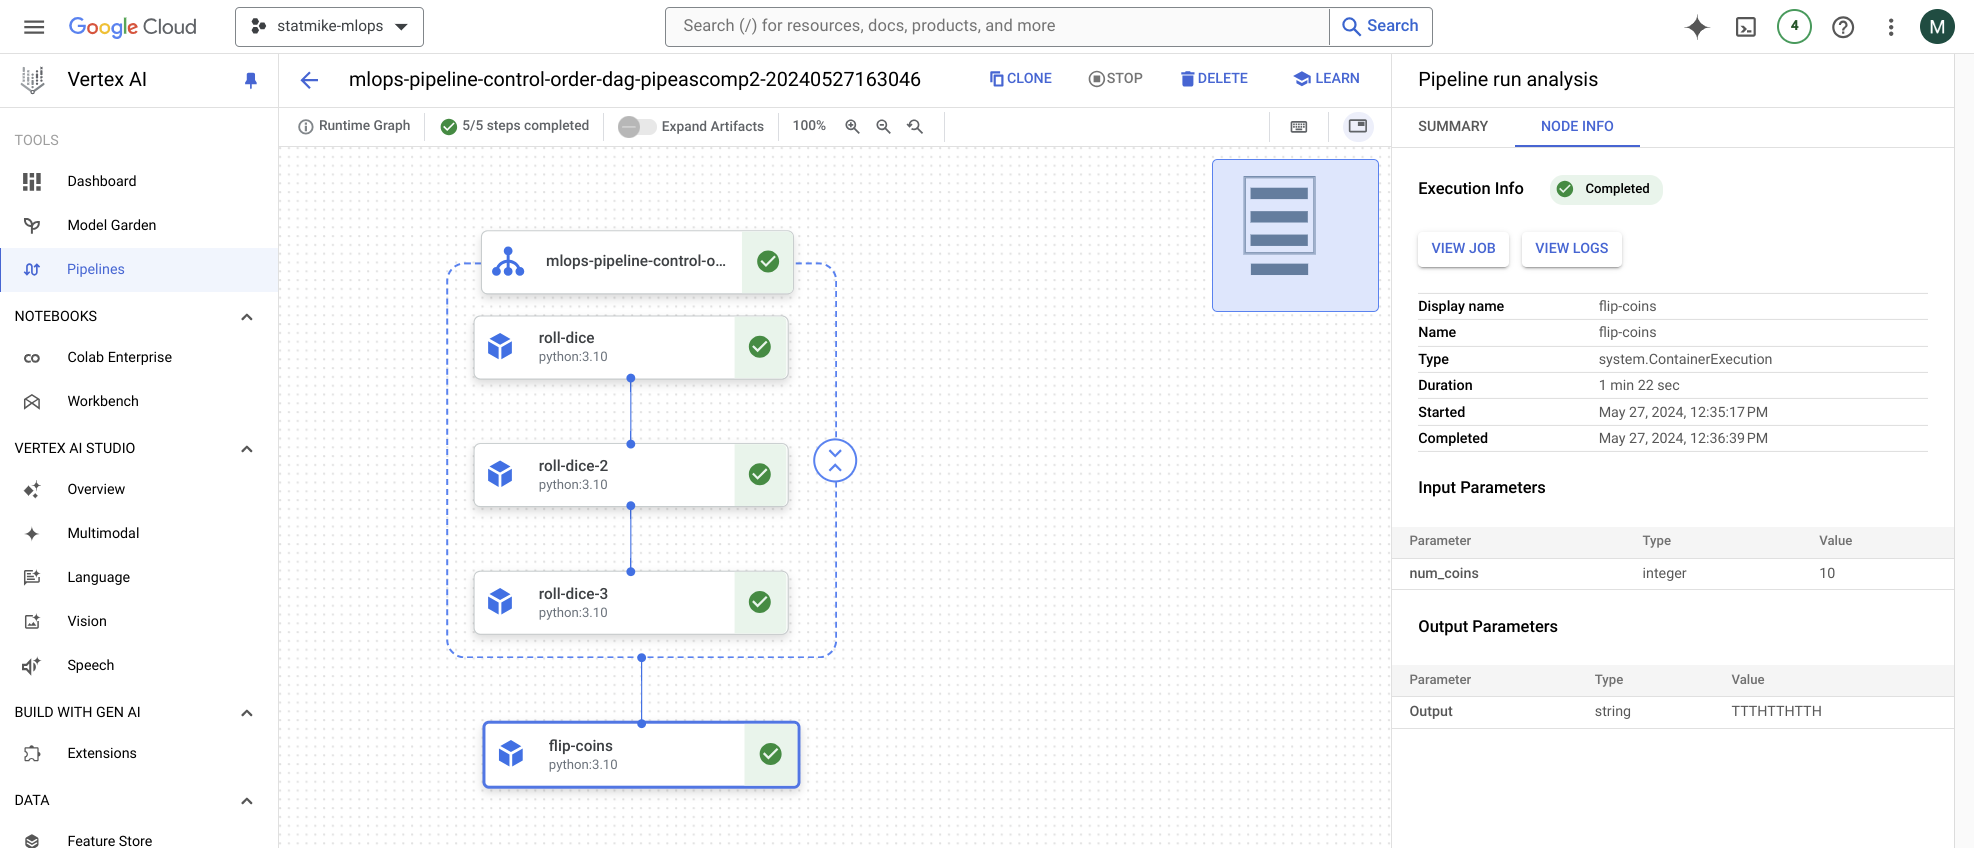
</center><p>

---
## Exit Handling

When a tasks or group of task needs to be followed by specific actions the `kfp.dsl.ExistHandler` will help.  This allows setting a specific tasks as an exit task so that after that tasks finishes (or fails) additional task will run. [Reference](https://www.kubeflow.org/docs/components/pipelines/v2/pipelines/control-flow/#exit-handling-dslexithandler)


The pipeline below runs three task with the `roll_dice` component.  The `kfp.dsl.ExitHandler` runs task 'task_2a' after 'task_1c' is done.

In [30]:
pipeline_name = f"{SERIES}-{EXPERIMENT}-order-dag-exithandle"
pipeline_name

'mlops-pipeline-control-order-dag-exithandle'

In [31]:
@kfp.dsl.pipeline(name = pipeline_name)
def order_pipeline_dag_exithandle():
 
    task_2a = flip_coins(num_coins = 10)
    
    with kfp.dsl.ExitHandler(exit_task = task_2a, name = 'After Dice Roll Tasks, flip coins'):   
        task_1a = roll_dice()
        task_1b = roll_dice(num_dice = 2).after(task_1a)
        task_1c = roll_dice(num_dice = 3).after(task_1b)        

In [161]:
pipeline_job = pipeline_runner(order_pipeline_dag_exithandle, pipeline_name)

Creating PipelineJob
PipelineJob created. Resource name: projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-exithandle-20240327171309
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-exithandle-20240327171309')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlops-pipeline-control-order-dag-exithandle-20240327171309?project=1026793852137
PipelineJob run completed. Resource name: projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-exithandle-20240327171309


In [162]:
print(f'The Dashboard can be viewed here:\n{pipeline_job._dashboard_uri()}')

The Dashboard can be viewed here:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlops-pipeline-control-order-dag-exithandle-20240327171309?project=1026793852137


<p><center>
    <img alt="Order DAG - Exit Handle" src="../../architectures/notebooks/mlops/order-dag-exithandle.png" width="90%">
</center><p>

## Exit Handling: With Failures

A type of exit is an error.  The following pipeline alters the pipeline above by adding a component that forces an error.  This shows that the `kfp.dsl.ExitHandler` still executes its `exit_task` after the failure.

**Notice**: The pipeline does fail!  But the `exit_task` still completes after the failure.  The downstream task from the failure does not commence though.  

In [32]:
@kfp.dsl.component(base_image = 'python:3.10')
def force_fail():
    import sys
    sys.exit(1)

In [33]:
pipeline_name = f"{SERIES}-{EXPERIMENT}-order-dag-exithandle-failure"
pipeline_name

'mlops-pipeline-control-order-dag-exithandle-failure'

In [34]:
@kfp.dsl.pipeline(name = pipeline_name)
def order_pipeline_dag_exithandle_failure():
 
    task_2a = flip_coins(num_coins = 10)
    
    with kfp.dsl.ExitHandler(exit_task = task_2a, name = 'After Dice Roll Tasks, flip coins'):   
        task_1a = roll_dice()
        task_1b = roll_dice(num_dice = 2).after(task_1a)
        task_fail = force_fail().after(task_1b)
        task_1c = roll_dice(num_dice = 3).after(task_fail)        

In [169]:
pipeline_job = pipeline_runner(order_pipeline_dag_exithandle_failure, pipeline_name)

Creating PipelineJob
PipelineJob created. Resource name: projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-exithandle-failure-20240327172344
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-exithandle-failure-20240327172344')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlops-pipeline-control-order-dag-exithandle-failure-20240327172344?project=1026793852137
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-exithandle-failure-20240327172344 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-exithandle-failure-20240327172344 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/loc

RuntimeError: Job failed with:
code: 9
message: "The DAG failed because some tasks failed. The failed tasks are: [exit-handler-1].; Job (project_id = statmike-mlops-349915, job_id = 7035289196877053952) is failed due to the above error.; Failed to handle the job: {project_number = 1026793852137, job_id = 7035289196877053952}"


In [170]:
print(f'The Dashboard can be viewed here:\n{pipeline_job._dashboard_uri()}')

The Dashboard can be viewed here:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlops-pipeline-control-order-dag-exithandle-20240327172303?project=1026793852137


**Notice**: The pipeline does fail!  But the `exit_task` still completes after the failure.  The downstream task from the failure does not commence though.  

<p><center>
    <img alt="Order DAG - Exit Handle" src="../../architectures/notebooks/mlops/order-dag-exithandle-failure.png" width="90%">
</center><p>

---
## Exit Handling: Error Handling

The example above shows how the `kfp.dsl.ExitHandler` can continue with an `exit_task` even after a failure.  There are times where tasks still can be run even when an upstream task failed.  Like the 'task_1c' in that prior pipeline which has no inputs from the failed task, it just happens to be run after the task.  For this, the `.ignore_upstream_failure()` task method is a great solution. [Reference](https://www.kubeflow.org/docs/components/pipelines/v2/pipelines/control-flow/#ignore-upstream-failure)

The prior pipeline is updated with the `.ignotre_upstream_failure()` method added to 'task_1c'.

**Notice**: As before, the pipeline fails and `exit_task` still completes after the failure.  This time, the downstream task from the failure does continue and complete successfully.

In [35]:
pipeline_name = f"{SERIES}-{EXPERIMENT}-order-dag-errorhandle"
pipeline_name

'mlops-pipeline-control-order-dag-errorhandle'

In [36]:
@kfp.dsl.pipeline(name = pipeline_name)
def order_pipeline_dag_errorhandle():
 
    task_2a = flip_coins(num_coins = 10)
    
    with kfp.dsl.ExitHandler(exit_task = task_2a, name = 'After Dice Roll Tasks, flip coins'):   
        task_1a = roll_dice()
        task_1b = roll_dice(num_dice = 2).after(task_1a)
        task_fail = force_fail().after(task_1b)
        task_1c = roll_dice(num_dice = 3).after(task_fail).ignore_upstream_failure()        

In [173]:
pipeline_job = pipeline_runner(order_pipeline_dag_errorhandle, pipeline_name)

Creating PipelineJob
PipelineJob created. Resource name: projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-errorhandle-20240327184805
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-errorhandle-20240327184805')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlops-pipeline-control-order-dag-errorhandle-20240327184805?project=1026793852137
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-errorhandle-20240327184805 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-control-order-dag-errorhandle-20240327184805 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlo

RuntimeError: Job failed with:
code: 9
message: "The DAG failed because some tasks failed. The failed tasks are: [exit-handler-1].; Job (project_id = statmike-mlops-349915, job_id = 1551030750646632448) is failed due to the above error.; Failed to handle the job: {project_number = 1026793852137, job_id = 1551030750646632448}"


In [174]:
print(f'The Dashboard can be viewed here:\n{pipeline_job._dashboard_uri()}')

The Dashboard can be viewed here:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlops-pipeline-control-order-dag-exithandle-20240327172303?project=1026793852137


**Notice**: As before, the pipeline fails and `exit_task` still completes after the failure.  This time, the downstream task from the failure does continue and complete successfully.
<p><center>
    <img alt="Order DAG - Exit Handle" src="../../architectures/notebooks/mlops/order-dag-errorhandle.png" width="90%">
</center><p>